# Figure 5

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from scipy import stats
import os
import pickle
from sklearn.preprocessing import StandardScaler
import mne
from matplotlib.colors import Normalize
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import bootstrap
import matplotlib as mpl

# Figure 5A

In [16]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def highlight_interval_visualization(load_path, signal_data_path, subject_ids, save_root, sampling_rate=125):
    """
    Visualizes highlighted intervals and signal data for different channel positions. 
    A plot is generated for each minute of data.

    Arguments:
    - load_path: str, path to the highlighted interval data (pickle format).
    - signal_data_path: str, path to processed signal data (pickle format, organized by channel).
    - subject_ids: list, list of subject IDs to visualize.
    - save_root: str, directory to save the generated images.
    - sampling_rate: int, the EEG data sampling rate (default is 125Hz).

    Returns:
    - None: This function saves visualization results as image files in the specified folder.
    """
    
    # Load the highlight regions and signal data from the provided paths
    with open(load_path, 'rb') as file:
        highlight_regions_per_channel = pickle.load(file)

    with open(signal_data_path, 'rb') as file:
        signal_data = pickle.load(file)
    
    # Configure plot appearance
    plt.rcParams.update({
        'font.family': 'Times New Roman',  # Recommended journal font
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.linewidth': 1.5,
        'legend.fontsize': 10,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'pdf.fonttype': 42,
        'ps.fonttype': 42,
        'figure.dpi': 300
    })

    # Process each subject
    for subject_id in subject_ids:
        # Extract highlight intervals for the current subject
        subject_highlight = {}
        for channel, highlights in highlight_regions_per_channel.items():
            highlight_data = next((item for item in highlights if item['subject_id'] == subject_id), None)
            if highlight_data:
                subject_highlight[channel] = highlight_data['highlight_intervals']

        # Extract signal data for the current subject
        subject_signal = {}
        for channel, signals in signal_data.items():
            signal_data_item = next((item for item in signals if item['subject_id'] == subject_id), None)
            if signal_data_item:
                subject_signal[channel] = signal_data_item['processed_data']

        # Calculate the number of minutes of signal data
        num_samples_per_minute = sampling_rate * 10
        total_samples = len(next(iter(subject_signal.values())))  # Get the number of samples from one channel
        num_minutes = total_samples // num_samples_per_minute

        # Generate one plot for each minute
        for minute in range(num_minutes):
            fig, ax = plt.subplots(figsize=(6.5, 8))  # Standard size for Nature journal (inches)
            plt.subplots_adjust(left=0.15, right=0.95, top=0.93, bottom=0.08)  # Adjust layout margins

            num_channels = len(subject_signal)
            bar_height = 0.8

            # Plot the signal data for each channel
            for channel_id, signal in subject_signal.items():
                signal_start = minute * num_samples_per_minute
                signal_end = (minute + 1) * num_samples_per_minute
                signal_segment = signal[signal_start:signal_end]
                signal_segment = normalize_signal(signal_segment)
                time_segment = np.linspace(signal_start / sampling_rate, signal_end / sampling_rate, len(signal_segment))

                # Plot the signal waveform for the current channel
                ax.plot(time_segment, signal_segment + channel_id - 0.5,
                        color="#2f2f2f", alpha=0.95, linewidth=1.2, solid_capstyle='round')

                # Plot the highlighted intervals for the current channel
                if channel_id not in subject_highlight:
                    continue
                channel_highlights = subject_highlight[channel_id]
                for highlight in channel_highlights:
                    start, end = highlight
                    start_time = start / sampling_rate
                    end_time = end / sampling_rate

                    # Check if the highlight interval falls within the current minute's time window
                    if start_time >= signal_start / sampling_rate and end_time <= signal_end / sampling_rate:
                        ax.add_patch(patches.Rectangle(
                            (start_time, channel_id - 0.5),
                            end_time - start_time,
                            bar_height,
                            color='orange',
                            alpha=0.45,
                            edgecolor="orange",
                            linewidth=0.7,
                            linestyle="-"
                        ))

            # Customize the plot appearance
            channel_labels = ["Fp1", "Fp2", "Fz", "F3", "F4", "F7", "F8", "FCz", "FC3", "FC4", "FT7", "FT8", "Cz", 
                              "C3", "C4", "T3", "T4", "CP3", "CP4", "TP7", "TP8", "Pz", "P3", "P4", "T5", "T6", "Oz", "O1", "O2"]
            ax.set_xlim(minute * 10, (minute + 1) * 10)
            ax.set_ylim(-0.5, num_channels - 0.5)
            ax.set_yticks(range(num_channels))
            ax.set_yticklabels(channel_labels, fontstyle='italic', color="black")
            ax.yaxis.set_tick_params(width=0.5)
            ax.xaxis.set_tick_params(width=0.5)
            ax.set_xlabel("Time (s)", labelpad=3)
            ax.set_ylabel("EEG Channels", labelpad=3)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_linewidth(0.5)
            ax.spines['bottom'].set_linewidth(0.5)
            ax.invert_yaxis()

            # Title the plot
            ax.set_title(f"Subject {subject_id} | Time window: {minute + 1}", fontweight='semibold', pad=12)

            # Save the plot as an image
            save_path = os.path.join(save_root, f"{subject_id}_second_{minute + 1}.png")
            plt.savefig(save_path, dpi=600, bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
            plt.close()

def normalize_signal(signal):
    """Normalize the signal data to be between -1 and 1."""
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal)) * 2 - 1

# If necessary, please contact the corresponding author to obtain the data.

# Figure 5B

In [17]:

# 读取 .npz 文件
data = np.load('../dataset/figure5_B_plot_variables.npz')

# 获取文件中的变量
freqs_tar = data['freqs_tar']
psd_tar = data['psd_tar']
ci_lower_tar = data['ci_lower_tar']
ci_upper_tar = data['ci_upper_tar']
freqs_ori = data['freqs_ori']
psd_ori = data['psd_ori']
ci_lower_ori = data['ci_lower_ori']
ci_upper_ori = data['ci_upper_ori']
mean_psd_tar = data['mean_psd_tar']
mean_psd_ori = data['mean_psd_ori']
freqs_show = data['freqs_show']
sig_freqs = data['sig_freqs']
pvals_corrected = data['pvals_corrected']
ci_lower_diff = data['ci_lower_diff']
ci_upper_diff = data['ci_upper_diff']

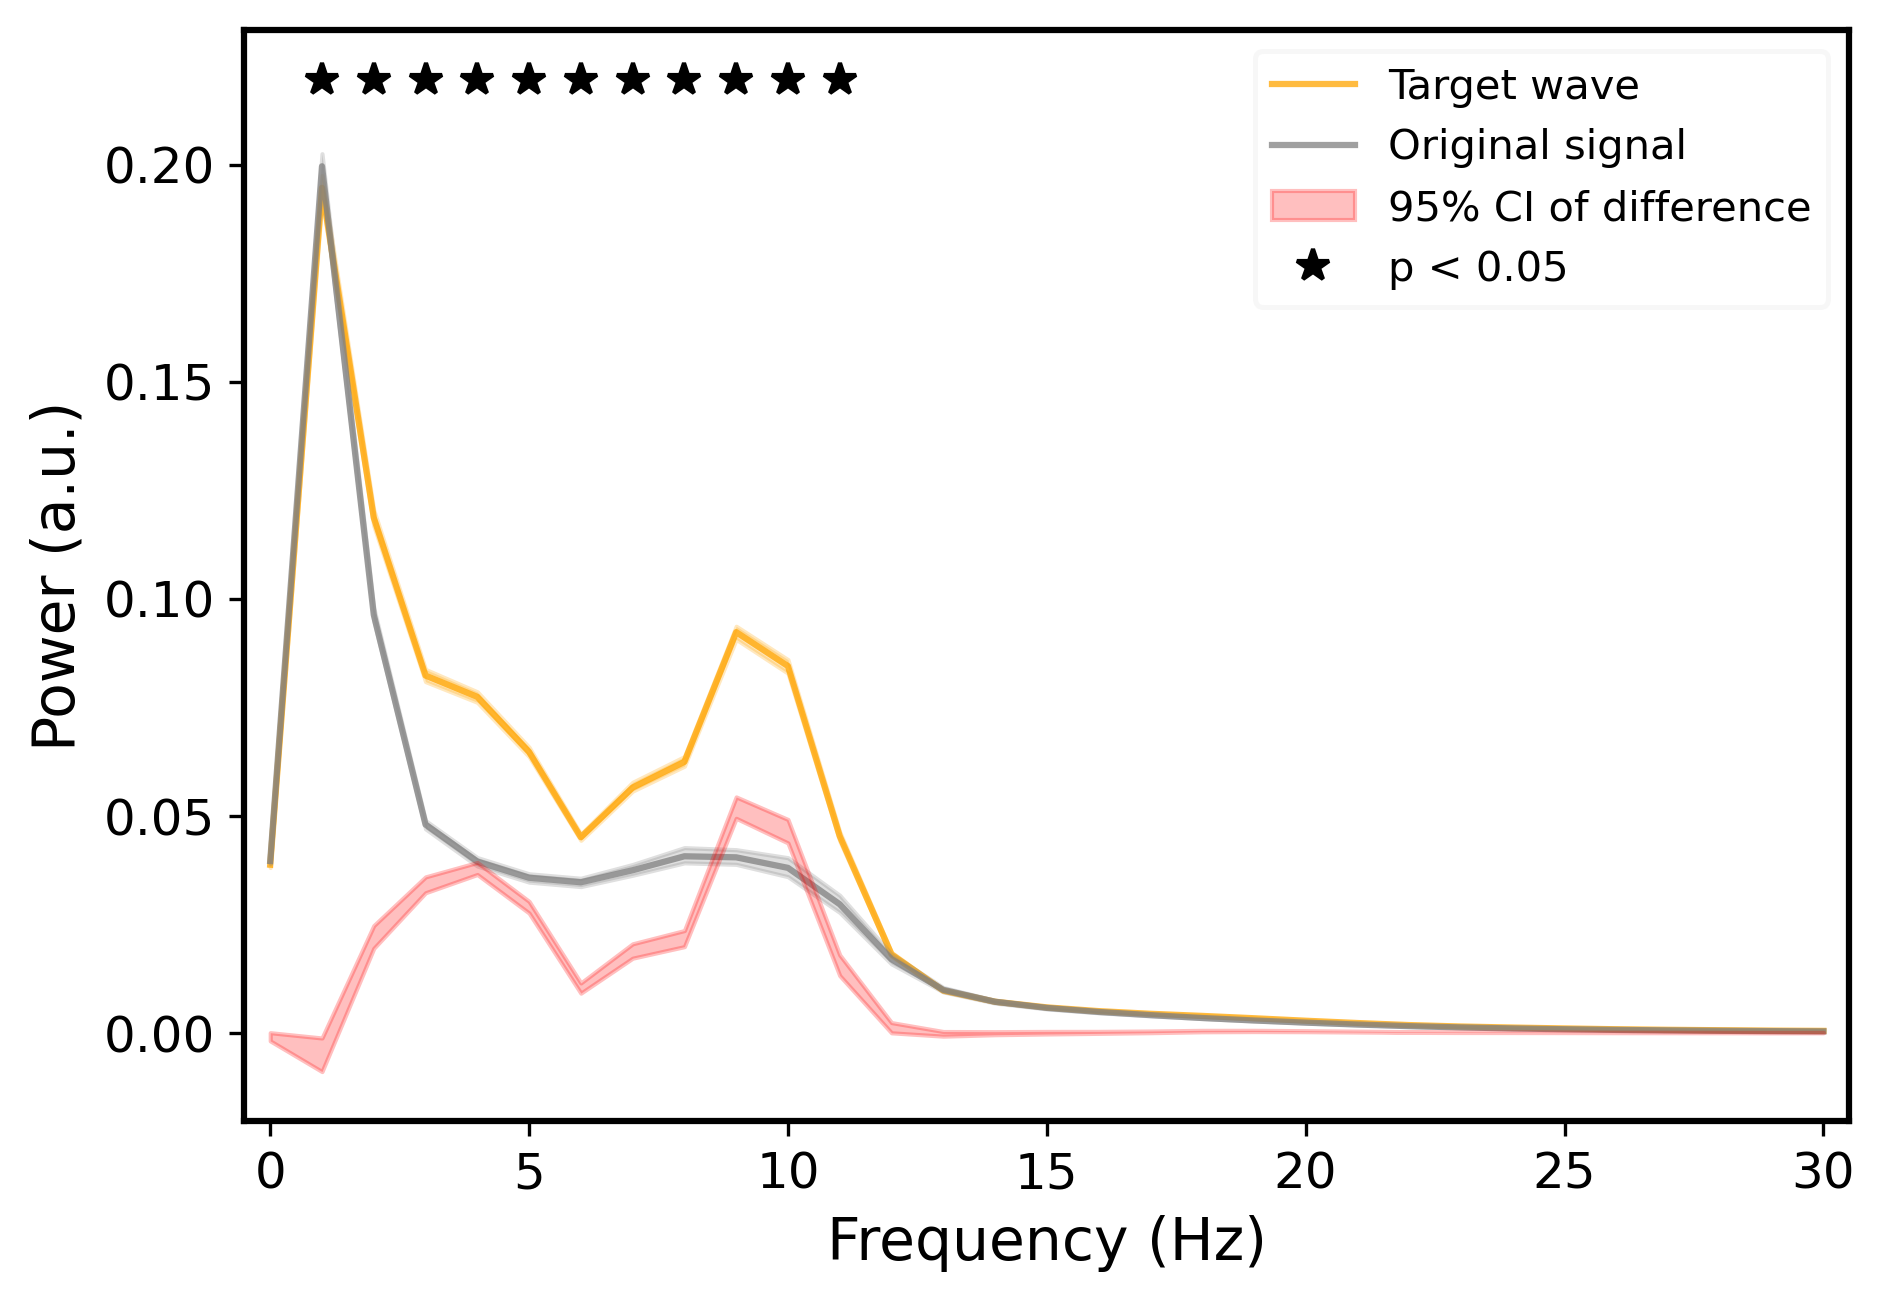

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Define frequency limit and mask for frequency range
freq_limit = 30
freq_mask = freqs_tar <= freq_limit
freqs_show = freqs_tar[freq_mask]

# Update plotting parameters for a professional look
plt.rcParams.update({
    'font.family': 'DejaVu Sans',   
    'font.size': 12,                   # Base font size
    'axes.labelsize': 14,              # Axis label font size
    'axes.linewidth': 1.5,             # Axis line width
    'legend.fontsize': 10,             # Legend font size
    'xtick.labelsize': 12,             # X-axis tick label font size
    'ytick.labelsize': 12,             # Y-axis tick label font size
    'pdf.fonttype': 42,                # Ensure the output text is editable
    'ps.fonttype': 42,
    'figure.dpi': 300                  # High resolution for the figure
})

# Create the plot with specified figure size
fig, ax = plt.subplots(figsize=(4.3*1.5, 3*1.5))

# Plot the target wave (mean and confidence intervals)
ax.plot(freqs_tar[freq_mask], mean_psd_tar, color='orange', alpha=0.75, label='Target wave', zorder=1)
ax.fill_between(freqs_tar[freq_mask], ci_lower_tar, ci_upper_tar, color='orange', alpha=0.25)

# Plot the original signal (mean and confidence intervals)
ax.plot(freqs_tar[freq_mask], mean_psd_ori, color='gray', alpha=0.75, label='Original signal', zorder=2)
ax.fill_between(freqs_tar[freq_mask], ci_lower_ori, ci_upper_ori, color='gray', alpha=0.25)

# Plot the confidence interval of the difference between target and original signals
ax.fill_between(freqs_tar[freq_mask], ci_lower_diff, ci_upper_diff, color='red', alpha=0.25, label='95% CI of difference', zorder=3)

# Highlight the significant frequencies with stars
sig_freqs = freqs_show[pvals_corrected < 0.05]  # Frequencies with p-values < 0.05
sig_freqs = sig_freqs[sig_freqs < 16]  # Limit to frequencies below 16 Hz
if len(sig_freqs) > 0:
    ax.plot(sig_freqs, [np.max([mean_psd_tar, mean_psd_ori]) * 1.1] * len(sig_freqs),
            lw=0, marker='*', color='k', markersize=8, label='p < 0.05')

# Adjust plot formatting
ax.set_xlim(-0.5, freq_limit + 0.5)
ax.set_xlabel('Frequency (Hz)')  # X-axis label
ax.set_ylabel('Power (a.u.)')  # Y-axis label with units

# Customize grid if needed (commented out for clarity)
# ax.grid(True, linestyle=':', alpha=0.6)  # Optional grid lines for better visualization

# Add legend
legend = ax.legend(frameon=True, loc='upper right')
legend.get_frame().set_linewidth(1.2)  # Set legend border width
legend.get_frame().set_edgecolor('whitesmoke')  # Set legend border color

# Adjust layout to fit the plot nicely
plt.tight_layout()

# Show the plot (if running interactively)
# plt.show()


In [19]:
from scipy.signal import butter, filtfilt, welch
from scipy.stats import t

# Define the mapping of regions to channels in a dictionary
net_dict = {
    'Forehead': list(range(0, 2)), 
    'Frontal': list(range(2, 12)),
    'Center': [12, 13, 14, 17, 18], 
    'Temporal': [15, 16, 19, 20, 24, 25],
    'Parietal': [21, 22, 23],
    'Occipital': [26, 27, 28],
    'All': list(range(0, 29))  # Mapping includes all channels
}

fs = 125  # Sampling frequency

def calculate_power_per_subject(detection_datas, region_dict):
    """
    Calculate the total power of EEG signals in different frequency bands for each subject, 
    averaged over specified highlight intervals for each region.

    Arguments:
    - detection_datas: Data for the EEG signals with highlight intervals.
    - region_dict: Mapping of regions to channel indices.

    Returns:
    - subject_region_mean_intervals: List of dictionaries with average power for each region per subject.
    """
    subject_region_mean_intervals = []

    # Iterate over each subject's data
    for j, subject_data in enumerate(detection_datas[0]):  # Assuming the subject data is in the first element
        subject_id = subject_data['subject_id']
        
        # Store the region-wise mean power for each subject
        region_mean_per_subject = {}
        
        # Iterate through the regions and their channels
        for region, channels in region_dict.items():
            highlight_intervals_per_region = []

            # Iterate through each channel in the region
            for channel in channels:
                highlight_intervals = detection_datas[channel][j]['highlight_intervals']
                
                # Process each highlight interval
                for highlight_interval in highlight_intervals:
                    # Normalize the highlight interval
                    segment_normalized = highlight_interval / np.max(np.abs(highlight_interval))

                    # Calculate the power spectrum using Welch's method
                    frequencies, psd = welch(segment_normalized, fs=fs, nperseg=100)

                    # Calculate the total power of the signal
                    total_power = np.trapz(psd, frequencies) / len(highlight_interval) * fs
                    highlight_intervals_per_region.append(total_power)
                
            # Compute the average power for the region across channels
            region_mean_per_subject[region] = np.mean(highlight_intervals_per_region)

        # Store the region-wise power results for the subject
        subject_region_mean_intervals.append(region_mean_per_subject)

    return subject_region_mean_intervals

def calculate_center_frequency_per_subject(detection_datas, region_dict):
    """
    Calculate the center frequency of EEG signals for each subject, averaged over highlight intervals 
    for each region.

    Arguments:
    - detection_datas: Data for the EEG signals with highlight intervals.
    - region_dict: Mapping of regions to channel indices.

    Returns:
    - subject_region_mean_intervals: List of dictionaries with average center frequency for each region per subject.
    """
    subject_region_mean_intervals = []

    # Iterate over each subject's data
    for j, subject_data in enumerate(detection_datas[0]):
        subject_id = subject_data['subject_id']
        
        # Store the region-wise center frequency for each subject
        region_mean_per_subject = {}
        
        # Iterate through the regions and their channels
        for region, channels in region_dict.items():
            highlight_intervals_per_region = []

            # Iterate through each channel in the region
            for channel in channels:
                highlight_intervals = detection_datas[channel][j]['highlight_intervals']

                # Process each highlight interval
                for highlight_interval in highlight_intervals:
                    # Calculate the power spectral density using Welch's method
                    frequencies, psd = welch(highlight_interval, fs=fs, nperseg=100)
                    
                    # Calculate the center frequency as the weighted average of the frequencies
                    center_frequency = np.sum(frequencies * psd) / np.sum(psd)
                    highlight_intervals_per_region.append(center_frequency)
                
            # Compute the average center frequency for the region across channels
            region_mean_per_subject[region] = np.mean(highlight_intervals_per_region)

        # Store the region-wise center frequency results for the subject
        subject_region_mean_intervals.append(region_mean_per_subject)

    return subject_region_mean_intervals

def calculate_highlight_intervals_per_subject(detection_datas, region_dict):
    """
    Calculate the number of highlight intervals for each region in the EEG data for each subject.

    Arguments:
    - detection_datas: Data for the EEG signals with highlight intervals.
    - region_dict: Mapping of regions to channel indices.

    Returns:
    - subject_region_mean_intervals: List of dictionaries with the number of highlight intervals per region per subject.
    """
    subject_region_mean_intervals = []

    # Iterate over each subject's data
    for j, subject_data in enumerate(detection_datas[0]):
        subject_id = subject_data['subject_id']
        
        # Store the region-wise highlight interval count for each subject
        region_mean_per_subject = {}
        
        # Iterate through the regions and their channels
        for region, channels in region_dict.items():
            highlight_intervals_per_region = []

            # Iterate through each channel in the region
            for channel in channels:
                highlight_intervals = detection_datas[channel][j]['highlight_intervals']
                
                # Count the number of highlight intervals for the channel
                highlight_intervals_per_region.append(len(highlight_intervals))
            
            # Compute the average number of highlight intervals for the region
            region_mean_per_subject[region] = np.mean(highlight_intervals_per_region)

        # Store the region-wise highlight interval counts for the subject
        subject_region_mean_intervals.append(region_mean_per_subject)

    return subject_region_mean_intervals

def extract_region_means(subject_region_means, region_name):
    """
    Extract the region-specific means for all subjects.

    Arguments:
    - subject_region_means: List of dictionaries containing region-wise means for each subject.
    - region_name: The region to extract means for.

    Returns:
    - np.array: Array of region-specific means across subjects.
    """
    return np.array([subject[region_name] for subject in subject_region_means])

def mean_difference(data, n_group_A):
    """
    Calculate the difference in means between two groups.

    Arguments:
    - data: Combined data from both groups.
    - n_group_A: The number of samples in group A.

    Returns:
    - The difference in means between the two groups.
    """
    group_A = data[:n_group_A]
    group_B = data[n_group_A:]
    return np.mean(group_A) - np.mean(group_B)

def bootstrap_region_comparison(subject_region_mean_A, subject_region_mean_B, region_dict, confidence_level=0.95, n_resamples=10000):
    """
    Perform a bootstrap test to compare the means of two groups for each region.

    Arguments:
    - subject_region_mean_A: Region means for group A.
    - subject_region_mean_B: Region means for group B.
    - region_dict: Mapping of regions to channel indices.
    - confidence_level: Confidence level for the bootstrap test (default is 0.95).
    - n_resamples: Number of bootstrap resamples (default is 10,000).

    Returns:
    - results: Dictionary with mean differences, confidence intervals, and p-values for each region.
    """
    results = {}

    # Iterate over each region in the dictionary
    for region in region_dict.keys():
        # Extract region means for both groups
        group_A = extract_region_means(subject_region_mean_A, region)
        group_B = extract_region_means(subject_region_mean_B, region)
        
        # Record the sample size of group A
        n_group_A = len(group_A)
        
        # Combine data from both groups
        data = np.concatenate([group_A, group_B])
        
        # Perform the bootstrap test
        res = bootstrap(
            (data,),
            lambda x: mean_difference(x, n_group_A),
            confidence_level=confidence_level,
            n_resamples=n_resamples,
            method='BCa',
            paired=False,
            alternative='two-sided'
        )
        
        # Save the results for this region
        results[region] = {
            "mean_difference": mean_difference(data, n_group_A),
            "confidence_interval": res.confidence_interval,
            "p_value": (res.confidence_interval.low > 0) or (res.confidence_interval.high < 0)
        }
    
    return results


# Figure 5C

 Region: Forehead
 Mean Difference: -0.11079217501235661
 Confidence Interval: ConfidenceInterval(low=-0.6983727763491109, high=0.38003123652485166)
 Significant: False

 Region: Frontal
 Mean Difference: -0.26854654367822395
 Confidence Interval: ConfidenceInterval(low=-0.7584086376602386, high=-0.05483401689792122)
 Significant: True

 Region: Center
 Mean Difference: 0.04037735148980115
 Confidence Interval: ConfidenceInterval(low=-0.3831876590953789, high=0.5643803212128945)
 Significant: False

 Region: Temporal
 Mean Difference: -0.11704533166606268
 Confidence Interval: ConfidenceInterval(low=-0.7146070171272101, high=0.25957207828973117)
 Significant: False

 Region: Parietal
 Mean Difference: nan
 Confidence Interval: ConfidenceInterval(low=nan, high=nan)
 Significant: False

 Region: Occipital
 Mean Difference: nan
 Confidence Interval: ConfidenceInterval(low=nan, high=nan)
 Significant: False

 Region: All
 Mean Difference: -0.14658533160314668
 Confidence Interval: Confiden

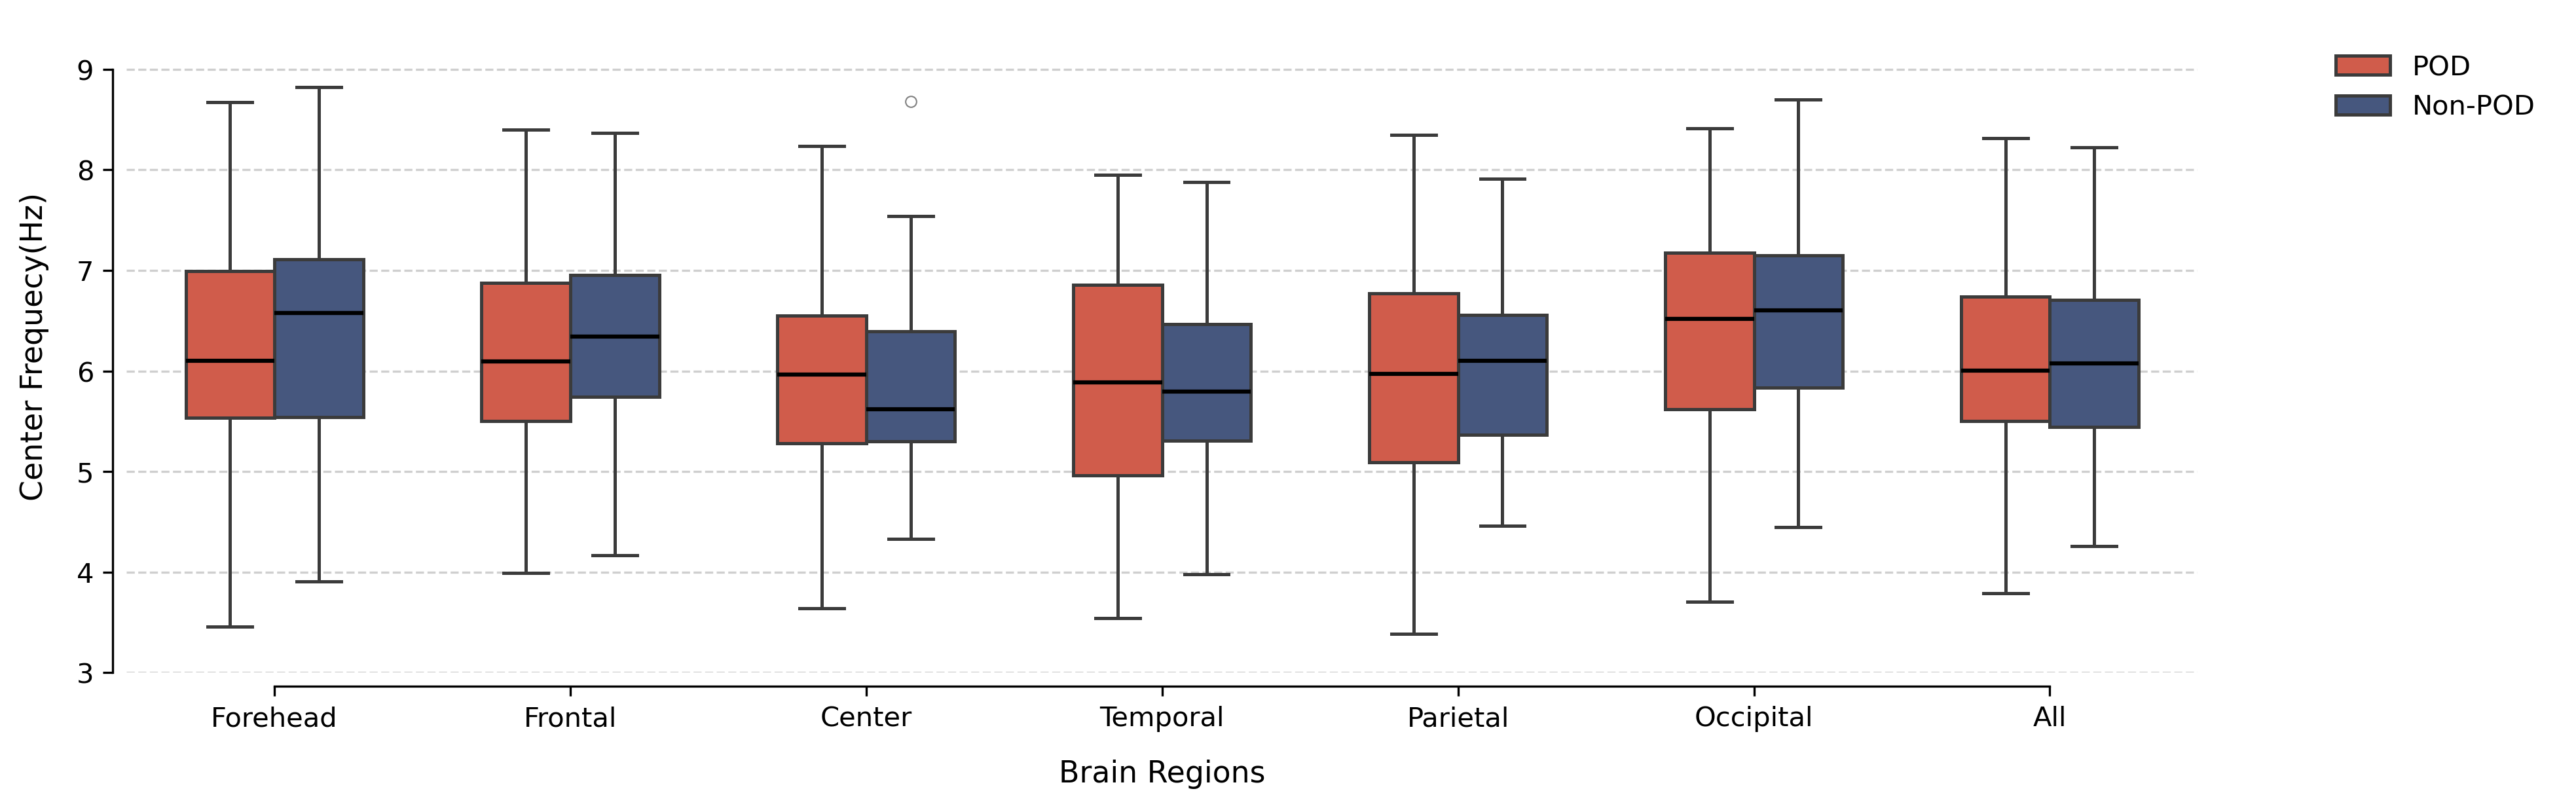

In [23]:


results = np.load('../dataset/figure5_C_results.npz', allow_pickle=True)
for region, result in results.items():
    result = result.item()
    print(f" Region: {region}")
    print(f" Mean Difference: {result['mean_difference']}")
    print(f" Confidence Interval: {result['confidence_interval']}")
    print(f" Significant: {result['p_value']}\n")


violin_data = np.load('../dataset/figure5_C_violin_data.npy', allow_pickle=True)
df_violin = pd.DataFrame(violin_data, columns=["Region", "Group", "Center Frequecy(Hz)"])
# 设置期刊级绘图参数
plt.rcParams.update({
    'font.family': 'DejaVu Sans',   
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'axes.linewidth': 0.8  # 坐标轴线宽
})

fig, ax = plt.subplots(figsize=(13, 4), constrained_layout=True)

clinical_palette = {"POD": "#E64B35", "non-POD": "#3C5488"}

# 增强型箱线图设计
box = sns.boxplot(
    x='Region', 
    y='Center Frequecy(Hz)', 
    hue='Group', 
    data=df_violin,
    palette=clinical_palette,
    width=0.6,
    linewidth=1.2,
    flierprops={
        'marker': 'o',
        'markersize': 4,
        'markerfacecolor': 'none',
        'markeredgecolor': 'gray',
        'markeredgewidth': 0.5
    },
    # boxprops={'facecolor': 'none', 'edgecolor': 'black'},
    whiskerprops={'linewidth': 1.2},
    medianprops={'color': 'black', 'linewidth': 1.5},
    ax=ax
)

# 坐标轴优化
ax.set_ylim(3, 9.5)
ax.set_ylabel("Center Frequecy(Hz)", labelpad=10)
ax.set_xlabel("Brain Regions", labelpad=10)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)

# 高级图例设计
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(
    handles[:2], 
    ['POD', 'Non-POD'],
    frameon=True,
    loc='upper right',
    bbox_to_anchor=(1.18, 1),  # 图例外置防止重叠
    ncol=1,
    # title='Experimental Group',
    title_fontproperties={'weight': 'bold'},
    edgecolor='none',
    borderpad=0.8
)

# 优化视觉层次
sns.despine(offset=5, trim=True)  # 移除顶部和右侧轴线
plt.savefig('/mnt/dataset1/UnonoU/POD-biomarker/plot/figure_5_C', dpi=300, bbox_inches='tight')
plt.show()

# Figure 5E

P<0.001
 Region: Forehead
 Mean Difference: 4.1409932659932664
 Confidence Interval: ConfidenceInterval(low=0.0651204432551943, high=8.433922505541565)
 Significant: True

 Region: Frontal
 Mean Difference: 3.00782828282828
 Confidence Interval: ConfidenceInterval(low=0.8044218482323163, high=5.141329964193222)
 Significant: True

 Region: Center
 Mean Difference: 1.8587542087542097
 Confidence Interval: ConfidenceInterval(low=-0.6844642950145202, high=4.1609418363543975)
 Significant: False

 Region: Temporal
 Mean Difference: 1.1926206509539838
 Confidence Interval: ConfidenceInterval(low=-2.0892432800833234, high=3.7251385643964396)
 Significant: False

 Region: Parietal
 Mean Difference: 2.957912457912462
 Confidence Interval: ConfidenceInterval(low=0.5745485752015511, high=5.48372614450687)
 Significant: True

 Region: Occipital
 Mean Difference: 4.186026936026938
 Confidence Interval: ConfidenceInterval(low=1.5976469976606926, high=6.049382715340185)
 Significant: True

 Region: 

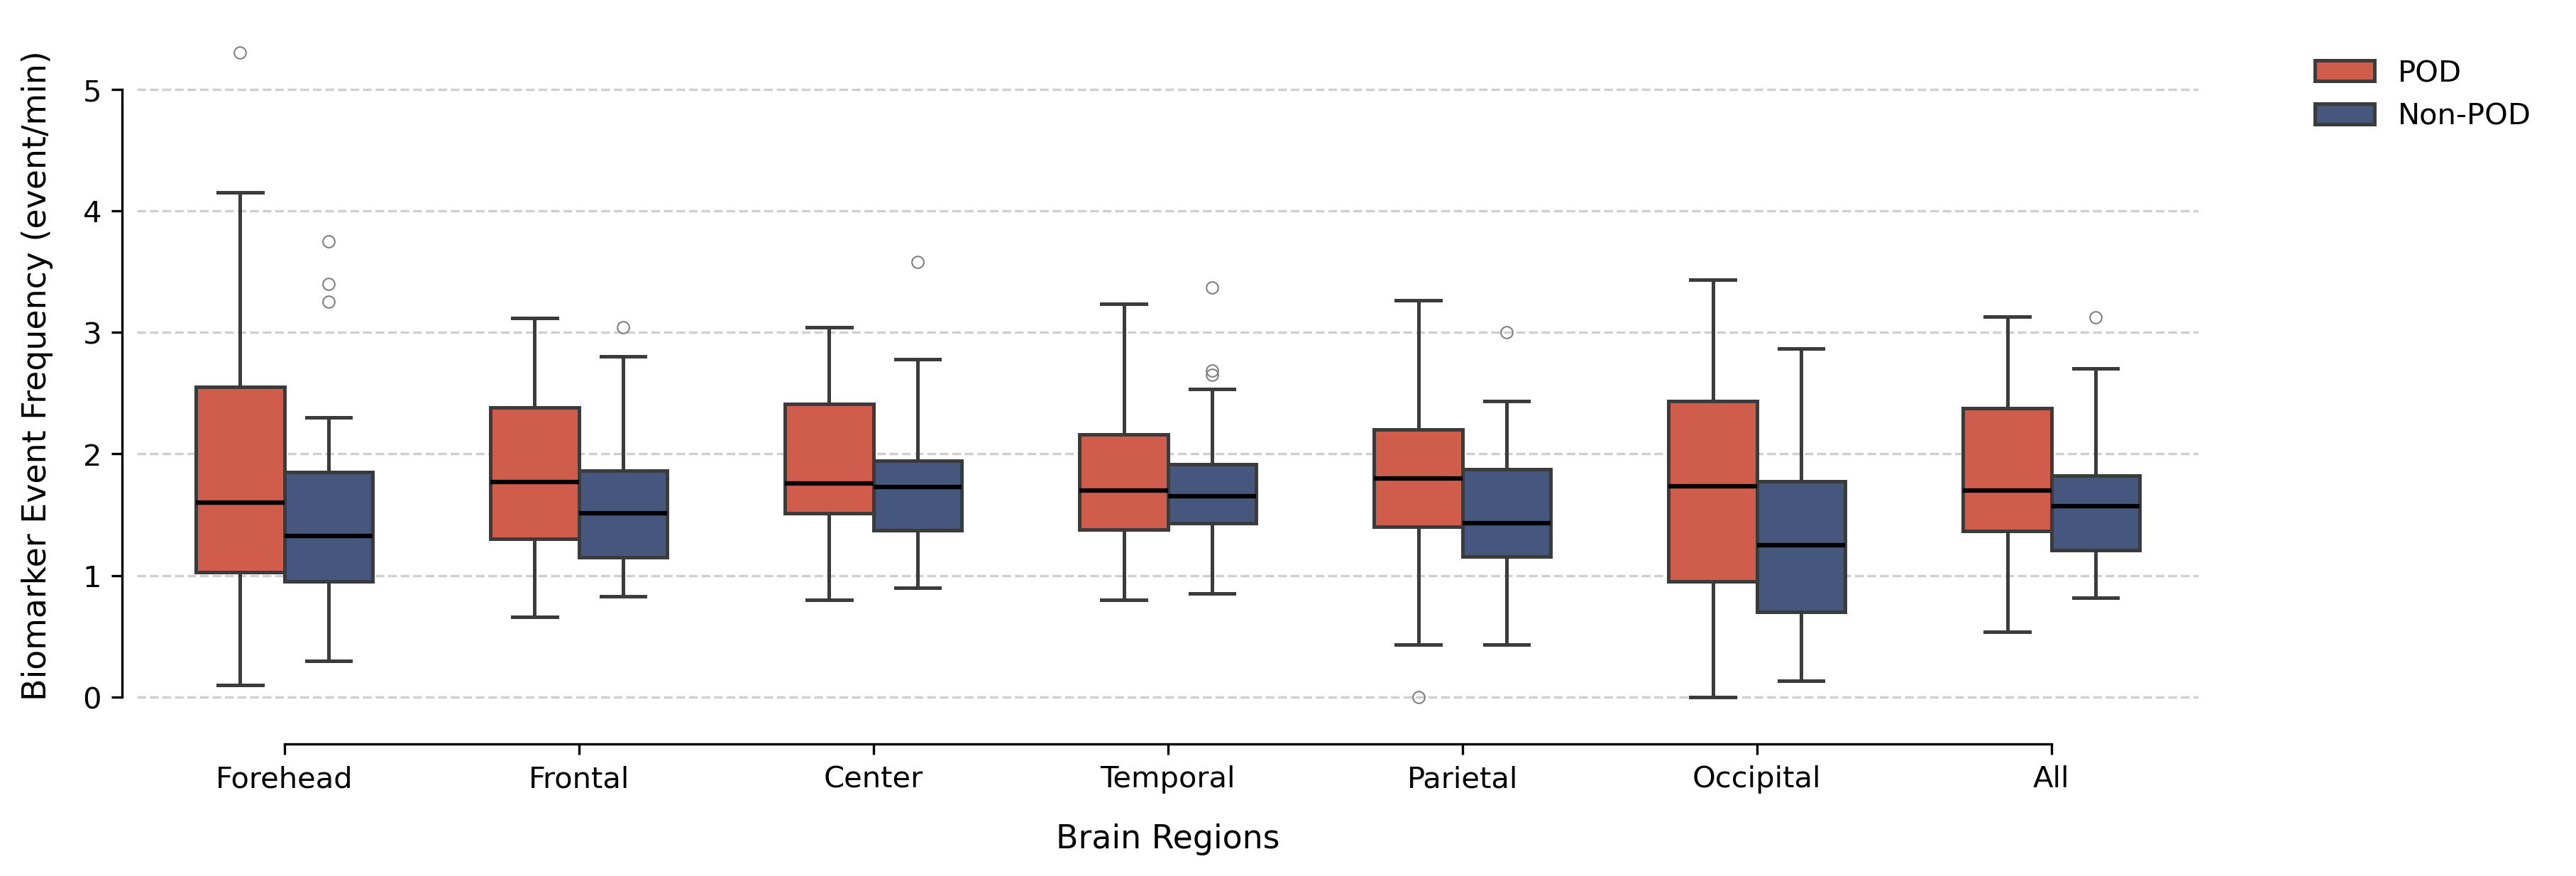

In [ ]:
# subject_region_mean_A = calculate_highlight_intervals_per_subject(detection_datas_A, net_dict)
# subject_region_mean_B = calculate_highlight_intervals_per_subject(detection_datas_B, net_dict)
# results = bootstrap_region_comparison(subject_region_mean_A, subject_region_mean_B, net_dict, confidence_level=0.999, n_resamples=1000)
# violin_data = []
# for region in regions:
#     data_A = [subject[region] for subject in subject_region_mean_A]  
#     data_B = [subject[region] for subject in subject_region_mean_B]  
    
#     for value in data_A:
#         violin_data.append((region, 'POD', value/10))
#     for value in data_B:
#         violin_data.append((region, 'non-POD', value/10))
# df_violin = pd.DataFrame(violin_data, columns=["Region", "Group", "Biomarker Event Frequency (event/min)"])

results = np.load('../dataset/figure5_E_results_99.9.npz', allow_pickle=True)
print('P<0.001')
for region, result in results.items():
    result = result.item()
    print(f" Region: {region}")
    print(f" Mean Difference: {result['mean_difference']}")
    print(f" Confidence Interval: {result['confidence_interval']}")
    print(f" Significant: {result['p_value']}\n")
    
results = np.load('../dataset/figure5_E_results_99.npz', allow_pickle=True)
print('P<0.01')
for region, result in results.items():
    result = result.item()
    print(f" Region: {region}")
    print(f" Mean Difference: {result['mean_difference']}")
    print(f" Confidence Interval: {result['confidence_interval']}")
    print(f" Significant: {result['p_value']}\n")

violin_data = np.load('../dataset/figure5_E_violin_data.npy', allow_pickle=True)
df_violin = pd.DataFrame(violin_data, columns=["Region", "Group", "Biomarker Event Frequency (event/min)"])
# 设置期刊级绘图参数
plt.rcParams.update({
    'font.family': 'DejaVu Sans',   
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'axes.linewidth': 0.8  # 坐标轴线宽
})

fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)

clinical_palette = {"POD": "#E64B35", "non-POD": "#3C5488"}

# 增强型箱线图设计
box = sns.boxplot(
    x='Region', 
    y='Biomarker Event Frequency (event/min)', 
    hue='Group', 
    data=df_violin,
    palette=clinical_palette,
    width=0.6,
    linewidth=1.2,
    flierprops={
        'marker': 'o',
        'markersize': 4,
        'markerfacecolor': 'none',
        'markeredgecolor': 'gray',
        'markeredgewidth': 0.5
    },
    # boxprops={'facecolor': 'none', 'edgecolor': 'black'},
    whiskerprops={'linewidth': 1.2},
    medianprops={'color': 'black', 'linewidth': 1.5},
    ax=ax
)

# 坐标轴优化
# ax.set_ylim(3, 9.5)
ax.set_ylabel("Biomarker Event Frequency (event/min)", labelpad=10)
ax.set_xlabel("Brain Regions", labelpad=10)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)

# 高级图例设计
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(
    handles[:2], 
    ['POD', 'Non-POD'],
    frameon=True,
    loc='upper right',
    bbox_to_anchor=(1.18, 1),  # 图例外置防止重叠
    ncol=1,
    # title='Experimental Group',
    title_fontproperties={'weight': 'bold'},
    edgecolor='none',
    borderpad=0.8
)

# 优化视觉层次
sns.despine(offset=5, trim=True)  # 移除顶部和右侧轴线
plt.savefig('/mnt/dataset1/UnonoU/POD-biomarker/plot/figure_5_E', dpi=300, bbox_inches='tight')
plt.show()